In [1]:
import sys
sys.path.append("..")  # Ensure project root is found

# Import configurations
from configs.plot_config import apply_plot_settings
from configs.math_functions import F, lognormal
from configs.parameters import *
from configs.filenames import *

import numpy as np
import os

C = float(os.getenv("C", C))
sig = float(os.getenv("sig", sig))
itr = int(os.getenv("itr", itr))

print(f"📢 Using parameters: C={C}, sig={sig}, itr={itr}")

📢 Using parameters: C=0.01, sig=0.12, itr=20000


In [2]:
output_dir = "../data/"

params = get_params_for_filename(param_keys, globals())
filename = get_filename("lognormal", "WCM", **params)
savefile = os.path.join(output_dir, filename)
print(f"✅ Opened {savefile}")

data = np.load(savefile, allow_pickle=True)      
t, synEE, synII, EE, II = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]

✅ Opened ../data/WCM_LOGNORMAL_delay_itr=20000_dt=0.005_tau=1_sig=0.12_wee=20_wei=21_wie=16_wii=6_ie=1.5_ii=-0.5_E0=0_I0=0.npy


In [3]:
synEE = synEE[::-1]
synII = synII[::-1]
EE = EE[::-1]
II = II[::-1]

synEI = np.array([synEE, synII])
EI = np.array([EE, II])

ZEZI = np.zeros((2, itr+1))
synaptic_input = np.zeros((2, itr+1))

ZEZI[0,0] = ZE1
ZEZI[1,0] = ZI1

for n in range(itr):
    s        = np.arange(1,n+1)                       ### opening array for delay function
    lognorm  = lognormal(s*dt, np.log(tau), sig)      ### calling the delay distribution    
    synEI_backwards = np.flip(synEI[:,:n+1], axis=1)  ### flipping the E/I_data since it is E/I [t -(!) s]
    ZEZI_backwards  = np.flip(ZEZI[:,:n+1], axis=1)   ### flipping the E/I_data since it is E/I [t -(!) s]
    
    integral = [+ lognorm * ZEZI_backwards[0,:n] * wee * F(synEI_backwards[0,:n]) * (1 - F(synEI_backwards[0,:n])) + lognorm * ZEZI_backwards[1,:n] * wie * F(synEI_backwards[0,:n]) * (1 - F(synEI_backwards[0,:n])),\
                - lognorm * ZEZI_backwards[0,:n] * wei * F(synEI_backwards[1,:n]) * (1 - F(synEI_backwards[1,:n])) - lognorm * ZEZI_backwards[1,:n] * wii * F(synEI_backwards[1,:n]) * (1 - F(synEI_backwards[1,:n]))]

    synaptic_input[:,n] = np.sum(integral, axis = 1) * dt
    
    print(n, end = '\r')    
    ZEZI[:,n+1] = [ZEZI[0,n] + dt * (- ZEZI[0,n] + synaptic_input[0,n]),\
                   ZEZI[1,n] + dt * (- ZEZI[1,n] + synaptic_input[1,n])]     
    
ZE = ZEZI[0,:]
ZI = ZEZI[1,:]

synEE = synEE[::-1]
synII = synII[::-1]
EE = EE[::-1]
II = II[::-1]
ZE = ZE[::-1]
ZI = ZI[::-1]
 
data = np.column_stack((t, synEE, synII, ZE, ZI))

params = get_params_for_filename(param_keys, globals())
filename = get_filename("lognormal", "PRC", **params)
savefile = os.path.join(output_dir, filename)
np.save(savefile, data, allow_pickle=True)

print(f"✅ Data saved to {savefile}")

✅ Data saved to ../data/PRC_WCM_LOGNORMAL_delay_itr=20000_dt=0.005_tau=1_sig=0.12_wee=20_wei=21_wie=16_wii=6_ie=1.5_ii=-0.5_ZE1=-5_ZI1=1.npy


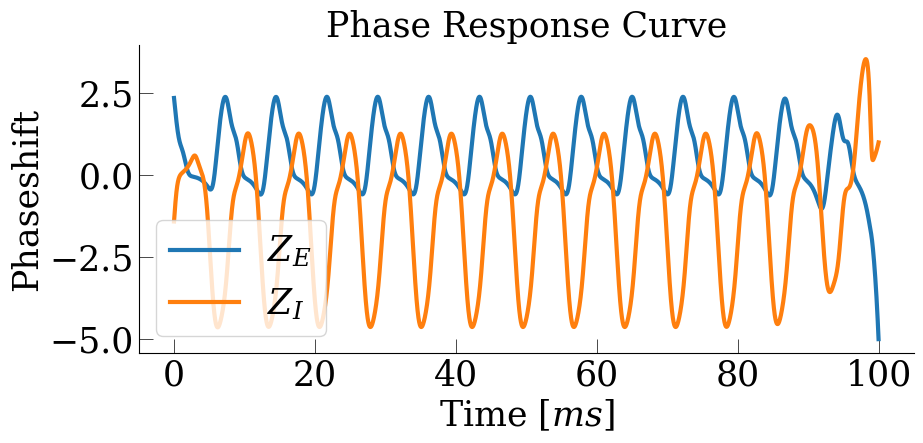

In [4]:
import matplotlib.pyplot as plt
from configs.plot_config import apply_plot_settings
apply_plot_settings()

data = np.load(savefile, allow_pickle=True)      
t, synEE, synII, ZE, ZI = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]

fig, ax = plt.subplots(figsize=(10, 4))  # Explicitly define figure size

ax.plot(t, ZE, linewidth=3, label = '$Z_E$')
ax.plot(t, ZI, linewidth=3, label = '$Z_I$')
ax.set_xlabel('Time $[ms]$')
ax.set_ylabel('Phaseshift')
ax.set_title('Phase Response Curve')
ax.legend()

plt.show()